In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout


In [ ]:
# --- 1. Carga de Datos Horarios ---
# Define la ruta de la carpeta procesada
PROCESSED_DATA_PATH = "data_processed" 

df_train_val = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, "df_horario_train_val.csv"), 
    index_col='timestamp', 
    parse_dates=True
)
df_test_final = pd.read_csv(
    os.path.join(PROCESSED_DATA_PATH, "df_horario_test_final.csv"), 
    index_col='timestamp', 
    parse_dates=True
)

# 2. Creación de la característica de Volatilidad
df_train_val['volatilidad'] = df_train_val['high'] - df_train_val['low']
df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']

# 3. Definir las características
features = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']

# --- 2. Creación y Ajuste del Escalador Horario ---
data_train_val = df_train_val[features].values 

# Inicializar un nuevo Escalador (diferente al diario)
scaler_horario = MinMaxScaler(feature_range=(0, 1))

# Ajustar y Transformar (Fit and Transform) los datos de entrenamiento
scaled_data_train_val = scaler_horario.fit_transform(data_train_val)

print("--- Escalador Horario Creado y Ajustado ---")
print(f"Forma del Array de entrenamiento escalado: {scaled_data_train_val.shape}")

# --- 3. Creación de Secuencias (Ventana de 3 Semanas) ---
# 3 semanas * 7 días/semana * 24 horas/día = 504 horas
TIMESTEP = 504 

X_train_horario = []
Y_train_horario = []

# Iterar sobre el array escalado para crear las secuencias
for i in range(TIMESTEP, len(scaled_data_train_val)):
    # X_train: Ventana de 504 horas anteriores
    X_train_horario.append(scaled_data_train_val[i-TIMESTEP:i, :]) 
    
    # Y_train: Precio de Cierre de la hora actual (índice 3)
    Y_train_horario.append(scaled_data_train_val[i, features.index('close')])

# Convertir a arreglos de NumPy
X_train_horario, Y_train_horario = np.array(X_train_horario), np.array(Y_train_horario)

print("\n--- Secuencias Horarias Creadas ---")
print(f"Forma de X_train_horario (muestras, pasos de tiempo, features): {X_train_horario.shape}")
print(f"Forma de Y_train_horario (muestras, valor a predecir): {Y_train_horario.shape}")

--- Escalador Horario Creado y Ajustado ---
Forma del Array de entrenamiento escalado: (43871, 6)

--- Secuencias Horarias Creadas ---
Forma de X_train_horario (muestras, pasos de tiempo, features): (43367, 504, 6)
Forma de Y_train_horario (muestras, valor a predecir): (43367,)


In [7]:
#Modelo LSTM:
# Una capa recurrente con 50 unidades
# Una capa de Dropout para prevenir el sobreajuste.
# Una capa Densa (Dense) de salida con 1 unidad, 
#       utilizando activación lineal, ya que es una tarea de regresión 
#       (prediciendo un valor continuo: el precio).

def crear_modelo_lstm(input_shape):
    """Define y compila el modelo LSTM."""
    
    # El input_shape debe ser (TIMESTEP, features) -> (60, 6)
    model = Sequential()
    
    # Capa LSTM
    model.add(LSTM(
        units=50, 
        return_sequences=False, # False porque solo nos interesa la salida del último paso de tiempo
        input_shape=input_shape
    ))
    
    # Capa de Dropout (para regularización)
    model.add(Dropout(0.2))
    
    # Capa de Salida (Predicción de 1 valor: Precio de Cierre)
    model.add(Dense(units=1))
    
    # Compilación: Usamos 'adam' como optimizador y 'mean_squared_error' (MSE) como métrica
    # MSE es común en tareas de regresión.
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

#Modelo GRU

def crear_modelo_gru(input_shape):
    """Define y compila el modelo GRU."""
    
    model = Sequential()
    
    # Capa GRU
    model.add(GRU(
        units=50, 
        return_sequences=False, 
        input_shape=input_shape
    ))
    
    # Capa de Dropout
    model.add(Dropout(0.2))
    
    # Capa de Salida
    model.add(Dense(units=1))
    
    # Compilación
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [ ]:
# Nota: Asegúrate de que las funciones crear_modelo_lstm y crear_modelo_gru estén definidas en esta notebook.

# Definir la forma de entrada: (Timesteps, Features) -> (504, 6)
input_shape_horario = (X_train_horario.shape[1], X_train_horario.shape[2]) 

# 1. Crear Modelos
modelo_lstm_horario = crear_modelo_lstm(input_shape_horario)
modelo_gru_horario = crear_modelo_gru(input_shape_horario)

# 2. Entrenamiento
print("\n--- Iniciando Entrenamiento LSTM Horario ---")
history_lstm_horario = modelo_lstm_horario.fit(
    X_train_horario, 
    Y_train_horario, 
    epochs=25,        
    batch_size=1024,
    validation_split=0.2, 
    verbose=1
)

print("\n--- Iniciando Entrenamiento GRU Horario ---")
history_gru_horario = modelo_gru_horario.fit(
    X_train_horario, 
    Y_train_horario, 
    epochs=25, 
    batch_size=1024, 
    validation_split=0.2, 
    verbose=1
)

# 3. Guardado
modelo_lstm_horario.save('modelo_lstm_horario.h5')
modelo_gru_horario.save('modelo_gru_horario.h5')
joblib.dump(scaler_horario, 'scaler_horario.pkl')

print("\n✅ Modelos y Escalador Horario Guardados con Éxito.")


--- Iniciando Entrenamiento LSTM Horario ---
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0039 - val_loss: 0.0012
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 0.0014 - val_loss: 3.5655e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 9.9036e-04 - val_loss: 5.1327e-04
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 7.8501e-04 - val_loss: 3.2014e-04
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 6.6461e-04 - val_loss: 1.1898e-04
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 5.5311e-04 - val_loss: 2.1783e-04
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 4.8984e-04 - val_loss: 5.7793e-05
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 4.5083e-04 - val_loss: 1.4828e-04
Epoch 9/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 4.2955e-04 - val_loss: 1.8247e-04
Epoch 10/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 3.9987e-04 - val_loss: 1.3937e-04
Epoch 11/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s


✅ Modelos y Escalador Horario Guardados con Éxito.



--- Datos de Enero 2025 de Testeo Final ---


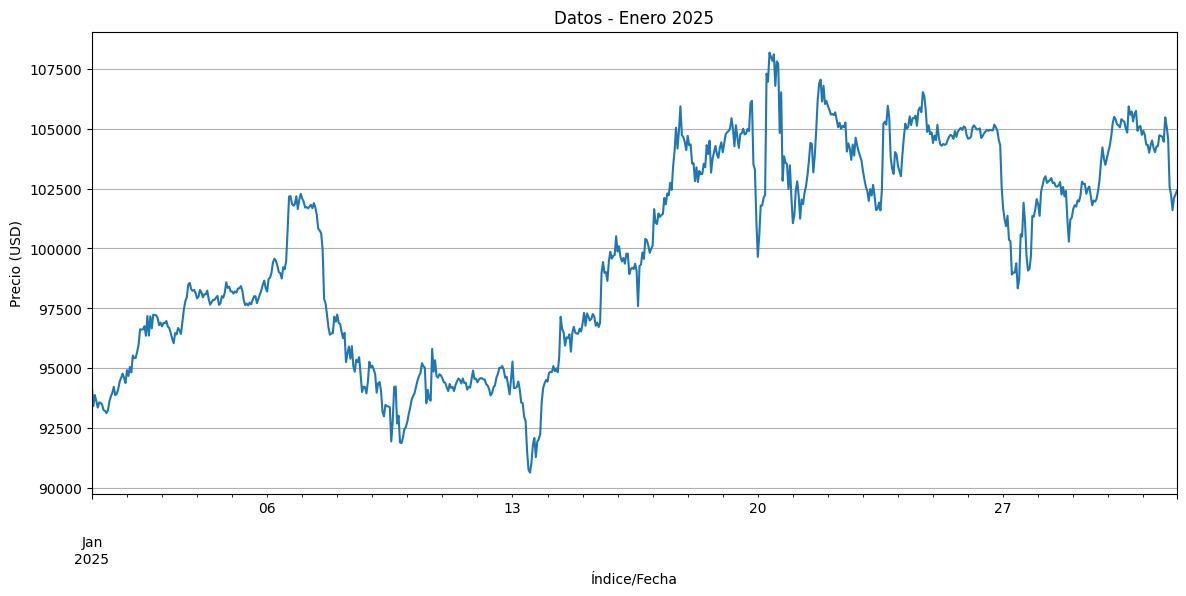

In [13]:
import matplotlib.pyplot as plt

def analizar_y_graficar_df(df: pd.DataFrame, titulo_grafico: str = 'Precio de Cierre (Serie Temporal)'):
    if 'close' in df.columns:
        plt.figure(figsize=(14, 6))
        # Graficamos el precio de cierre
        df['close'].plot(title=titulo_grafico, grid=True)
        plt.xlabel("Índice/Fecha") # Usamos 'Índice/Fecha' ya que no sabemos si el índice es datetime
        plt.ylabel("Precio (USD)")
        plt.show()
    else:
        print("\n Advertencia: La columna 'close' no se encontró en el DataFrame para graficar.")


#df_test_final
print("\n--- Datos de Enero 2025 de Testeo Final ---");

df_enero_25 = df_test_final.loc['2025-01-01':'2025-01-31']       # Desde 2025-01-01 en adelante  
analizar_y_graficar_df(df_enero_25, titulo_grafico='Datos - Enero 2025')




In [19]:
#Para predecir los valores de 2025:
# 1)Preparar los datos de 2025: Deben tener exactamente el mismo formato  
# (escalado, ventana de 60 días) que los datos de entrenamiento.
# Nota: La preparación de X_test es la misma para ambos modelos.

# Crear la característica de Volatilidad en el dataset final también
df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']
dataset_completo = pd.concat((df_train_val[features].iloc[-TIMESTEP:], df_test_final[features]), axis=0)
data_test = dataset_completo[features].values
scaled_test_data = scaler_horario.transform(data_test)
X_test = []
# Iteramos SÓLO sobre la longitud del dataset final
for i in range(TIMESTEP, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-TIMESTEP:i, :])

X_test = np.array(X_test)

print(f"\nForma de X_test (muestras de 2025, 60, 6): {X_test.shape}")

# -----------------------------------------------------------
# PREDICCIÓN Y DESESCALADO: MODELO LSTM
# -----------------------------------------------------------

# 2)Predecir: Pasar estos datos al modelo (modelo_lstm.predict()).
# Generamos las predicciones escaladas (entre 0 y 1)
predictions_scaled_lstm = modelo_lstm_horario.predict(X_test)
# 3)Desescalar: Convertir la predicción (que está entre 0 y 1) de vuelta a precios reales en dólares.
# 1. Crear un array fantasma para el desescalado
dummy_array_lstm = np.zeros(shape=(len(predictions_scaled_lstm), len(features)))

# 2. Colocar las predicciones escaladas en la columna de 'close' (índice 3)
close_idx = features.index('close')
dummy_array_lstm[:, close_idx] = predictions_scaled_lstm[:, 0]

# 3. Desescalar todo el array fantasma
predictions_descaled_lstm = scaler_horario.inverse_transform(dummy_array_lstm)

# 4. Obtener las predicciones reales (solo la columna 'close')
precios_predichos_reales_lstm = predictions_descaled_lstm[:, close_idx]

print("\n--- Resultados de la Predicción LSTM ---")
print(f"Predicciones desescaladas (precios reales en USD): {precios_predichos_reales_lstm[:5]}")
print(f"Predicciones desescaladas de Enero 2025: {precios_predichos_reales_lstm[:31]}")

# -----------------------------------------------------------
# PREDICCIÓN Y DESESCALADO: MODELO GRU
# -----------------------------------------------------------

# Generamos las predicciones escaladas (entre 0 y 1) usando modelo_gru
predictions_scaled_gru = modelo_gru_horario.predict(X_test)

# 1. Crear un array fantasma para el desescalado
dummy_array_gru = np.zeros(shape=(len(predictions_scaled_gru), len(features)))

# 2. Colocar las predicciones escaladas en la columna de 'close' (índice 3)
dummy_array_gru[:, close_idx] = predictions_scaled_gru[:, 0]

# 3. Desescalar todo el array fantasma
predictions_descaled_gru = scaler_horario.inverse_transform(dummy_array_gru)

# 4. Obtener las predicciones reales (solo la columna 'close')
precios_predichos_reales_gru = predictions_descaled_gru[:, close_idx]

print("\n--- Resultados de la Predicción GRU ---")
print(f"Predicciones desescaladas (precios reales en USD): {precios_predichos_reales_gru[:5]}")
print(f"Predicciones desescaladas de Enero 2025: {precios_predichos_reales_gru[:31]}")


Forma de X_test (muestras de 2025, 60, 6): (6400, 504, 6)
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step

--- Resultados de la Predicción LSTM ---
Predicciones desescaladas (precios reales en USD): [93584.84750562 93360.37177807 93278.48146458 93225.14917284
 93208.08507252]
Predicciones desescaladas de Enero 2025: [93584.84750562 93360.37177807 93278.48146458 93225.14917284
 93208.08507252 93120.09113318 93030.99308265 92985.04841123
 92958.9467267  92845.26669523 92686.83294373 92646.20413344
 92562.18623492 92543.72648844 92592.50587227 92635.4793681
 92760.92624737 92841.2038142  92895.33007352 92974.06312527
 93058.0810238  93262.1120859  93422.70443679 93570.22733679
 93626.96500514 93591.35431814 93685.27820293 93825.01649883
 93953.75710303 93973.17829463 94175.95017375]
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step

--- Resultados de la Predicción GRU ---
Predicciones desescaladas (precios reales en USD): [93720.86407844 93223.84656977 92980.656778   93067.77611242
 93063.53334811]
Pr

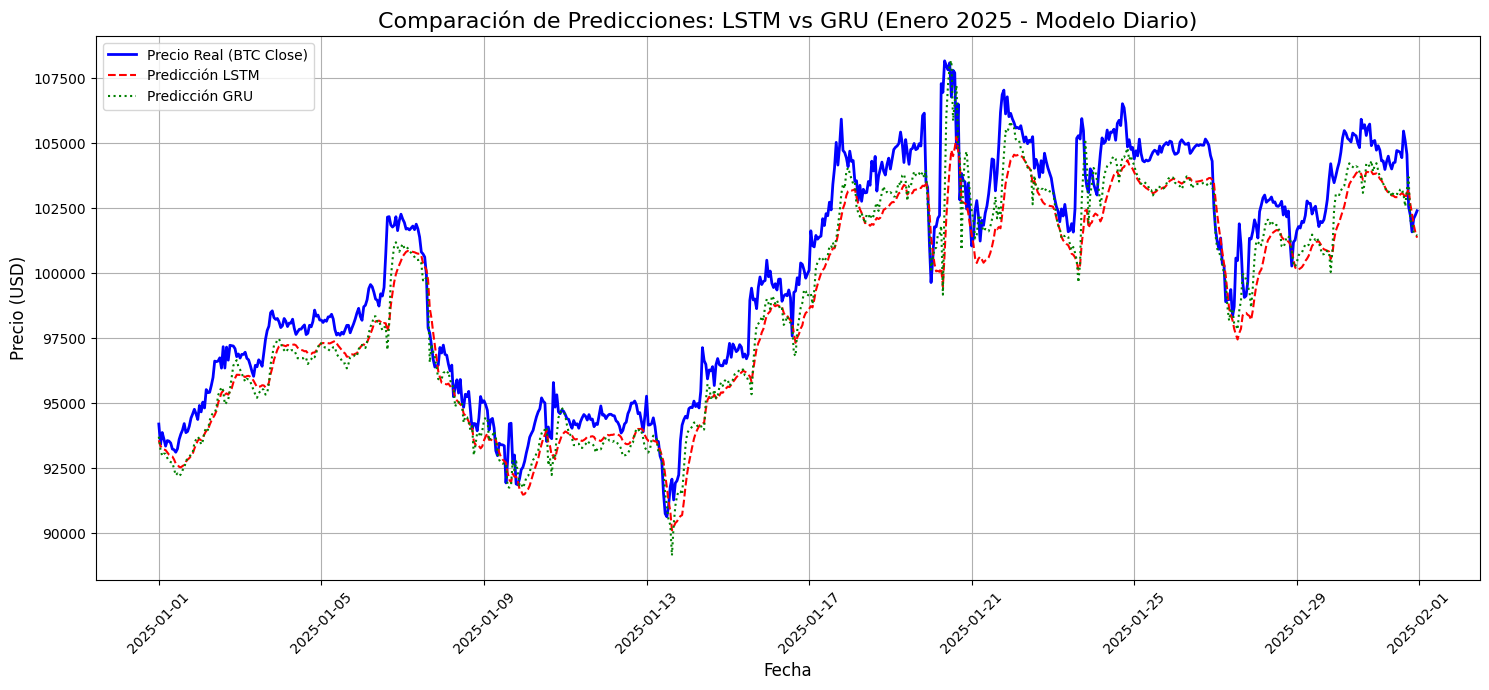

In [21]:
# 1. Obtener los arrays recortados para Enero 2025
minutos_de_enero = 744

precios_reales = df_test_final['close'].values
precios_reales_enero = precios_reales[:minutos_de_enero]

# Recortamos la predicción LSTM y GRU
precios_predichos_lstm_enero = precios_predichos_reales_lstm[:minutos_de_enero]
precios_predichos_gru_enero = precios_predichos_reales_gru[:minutos_de_enero] 

# 2. Obtener las fechas correspondientes para el eje X
fechas_enero = df_test_final.index[:minutos_de_enero]


# 3. Generar el Gráfico Comparativo
plt.figure(figsize=(15, 7))

# Gráfico 1: Precio Real (la verdad)
plt.plot(fechas_enero, precios_reales_enero, label='Precio Real (BTC Close)', color='blue', linewidth=2)

# Gráfico 2: Predicción LSTM
plt.plot(fechas_enero, precios_predichos_lstm_enero,label='Predicción LSTM', color='red', linestyle='--', linewidth=1.5)

# AÑADIDO: Gráfico 3: Predicción GRU
plt.plot(fechas_enero, precios_predichos_gru_enero, 
         label='Predicción GRU', color='green', linestyle=':', linewidth=1.5)

plt.title('Comparación de Predicciones: LSTM vs GRU (Enero 2025 - Modelo Diario)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()